# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
import numpy as np
import os
from imageio import imread
import datetime
import os
import matplotlib.pyplot as plt

In [ ]:
from skimage.transform import resize

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data.zip (Unzipped Files)/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data.zip (Unzipped Files)/Project_data/val.csv').readlines())
batch_size = 64

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

Adding some functions to reuse them

In [ ]:
def cropResize(image, y, z):
    h, w = image.shape
    
    # if smaller image crop at center for 120x120
    if w == 160:
        image = image[:120, 20:140]

    # resize every image
    return resize(image, (y,z))

In [ ]:
def normalizeImage(image):
    # applying normalization
    return image/255.0

In [ ]:
def preprocessImage(image, y, z):
    return normalizeImage(cropResize(image, y, z))

In [ ]:
def getImgTensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 100, 100, 3]

# define image tensor size
img_tensor = getImgTensor(20)
print ('# img_tensor =', img_tensor)

# img_tensor = [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]


In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    print('Printing currently X, Y and Z:', x , y , z)
    img_idx = img_tensor[0] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z)
                    batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z)
                    batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z)
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do     
        # write the code for the remaining data points which are left after full batches
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(folder_list)%batch_size
            batch_data = np.zeros((batch_size,x,y,z,3))  
            batch_labels = np.zeros((batch_size,5)) 
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z)
                    batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z)
                    batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z)
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data.zip (Unzipped Files)/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data.zip (Unzipped Files)/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers



In [ ]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

In [ ]:
#Base Model

def defineModel(img_tensor):
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

    model = Sequential()
    model.add(Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape)),
    model.add(MaxPooling3D(make3dFilter(2), padding='same')),
    model.add(BatchNormalization()),
    model.add(Conv3D(32, make3dFilter(3), activation='relu')),
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same')),
    model.add(BatchNormalization()),
    model.add(Conv3D(64, make3dFilter(3), activation='relu')),
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same')),
    model.add(BatchNormalization()),
    model.add(Flatten()),
    model.add(Dense(128, activation='relu')),
    model.add(BatchNormalization()),
    model.add(Dropout(0.25)),
    model.add(Dense(64, activation='relu')),
    model.add(BatchNormalization()),
    model.add(Dropout(0.25)),
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
#optimiser = #write your optimizer
#model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model = defineModel(img_tensor)
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 96, 96, 16)    6016      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 48, 48, 16)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 48, 48, 16)     64        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 6, 46, 46, 32)     13856     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 6, 23, 23, 32)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 23, 23, 32)     128       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 4, 21, 21, 64)     5

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

Source path =  /content/drive/MyDrive/Project_data.zip (Unzipped Files)/Project_data/train ; batch size = 64
Printing currently X, Y and Z: 20 100 100


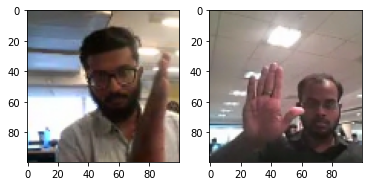

In [ ]:
# plot generated sample images
import matplotlib.pyplot as plt
sample_batch_data, sample_batch_labels = next(train_generator)

fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_batch_data[16,10,:,:,:])   
ax[1].imshow(sample_batch_data[25,10,:,:,:])
plt.show()

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
11/11 [==============================] - 7316s 728s/step - loss: 1.5562 - categorical_accuracy: 0.4711 - val_loss: 6.9380 - val_categorical_accuracy: 0.2000

Epoch 00001: saving model to model_init_2021-09-2106_58_59.590883/model-00001-1.55622-0.47106-6.93799-0.20000.h5
Epoch 2/10
11/11 [==============================] - 338s 34s/step - loss: 1.0103 - categorical_accuracy: 0.6166 - val_loss: 6.5003 - val_categorical_accuracy: 0.2812

Epoch 00002: saving model to model_init_2021-09-2106_58_59.590883/model-00002-1.01030-0.61660-6.50029-0.28125.h5
Epoch 3/10
11/11 [==============================] - 278s 28s/step - loss: 1.0244 - categorical_accuracy: 0.6403 - val_loss: 3.2276 - val_categorical_accuracy: 0.2679

Epoch 00003: saving model to model_init_2021-09-2106_58_59.590883/model-00003-1.02444-0.64032-3.22765-0.26786.h5
Epoch 4/10
11/11 [==============================] - 119s 12s/step - loss: 0.8496 - categorical_accuracy: 0.6856 - val_loss: 3.4876 - val_categorical_accuracy:

Evaluating Batch size 

In [ ]:
def EvaluateBatchSize(batch_size):
    #img_tensor = getImgTensor(n_frames)
    print("Current frames as", img_tensor[0])
    global callbacks_list
    num_epochs = 3
    train_generator = generator(train_path, train_doc, batch_size)
    val_generator = generator(val_path, val_doc, batch_size)
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    model = defineModel(img_tensor)
    model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
# Checking for batch_size=64, n_frames=30
img_tensor = getImgTensor(30)
print ('# img_tensor =', img_tensor)
EvaluateBatchSize(batch_size=64)

In [ ]:
# Checking for batch_size=64, n_frames=16
img_tensor = getImgTensor(16)
EvaluateBatchSize(batch_size=64)

In [ ]:
# Checking for batch_size=32, n_frames=30
img_tensor = getImgTensor(30)
EvaluateBatchSize(batch_size=32)

In [ ]:
# Checking for batch_size=32, n_frames=16
img_tensor = getImgTensor(16)
EvaluateBatchSize(batch_size=32)

Observation: We can see that batch size is not impacting training time but number of frames does. We will use batch size of 64 as it seems optimal. **Note**: These lines are commented later as it takes a lot of time to run again.

In [ ]:
def plotHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train Loss vs Validation Loss")

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train Accuracy vs Validation Accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

**Model 1**: With Frames-16, Epoc-20

In [ ]:
n_frames = 16
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model1 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d1")
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model1.summary())

model1_history = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_15 (Conv3D)           (None, 12, 96, 96, 16)    6016      
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 6, 48, 48, 16)     0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 6, 48, 48, 16)     64        
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 4, 46, 46, 32)     13856     
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 4, 23, 23, 32)     0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 4, 23, 23, 32)     128       
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 2, 21, 21, 64)     553

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.3885 - categorical_accuracy: 0.4811 Source path =  /content/drive/MyDrive/Project_data.zip (Unzipped Files)/Project_data/val ; batch size = 64
Printing currently X, Y and Z: 16 100 100
11/11 [==============================] - 212s 21s/step - loss: 1.3885 - categorical_accuracy: 0.4811 - val_loss: 4.5827 - val_categorical_accuracy: 0.2000

Epoch 00001: saving model to model_init_2021-09-2111_00_57.498439/model-00001-1.38847-0.48115-4.58275-0.20000.h5
Epoch 2/20
11/11 [==============================] - 90s 9s/step - loss: 0.8953 - categorical_accuracy: 0.6245 - val_loss: 4.5148 - val_categorical_accuracy: 0.1875

Epoch 00002: saving model to model_init_2021-09-2111_00_57.498439/model-00002-0.89525-0.62451-4.51476-0.18750.h5
Epoch 3/20
11/11 [==============================] - 83s 8s/step - loss: 1.0857 - categorical_accuracy: 0.5968 - val_loss: 6.4016 - val_categorical_accuracy: 0.2679

Epoch 00003: saving model to mode

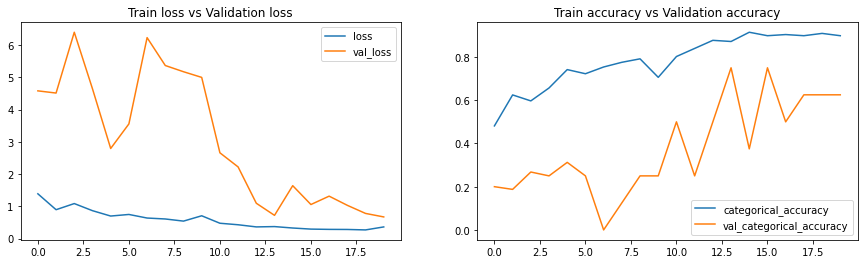

Max. Training Accuracy 0.9144384860992432
Max. Validaiton Accuracy 0.75


In [ ]:
plotHistory(model1_history)

**Model 2**: With Frames-30, Epoc-30

In [ ]:
n_frames = 30
num_epochs = 30
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model2 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d2")
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2.summary())

model2_history = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 26, 96, 96, 16)    6016      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 13, 48, 48, 16)    0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 13, 48, 48, 16)    64        
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 11, 46, 46, 32)    13856     
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 11, 23, 23, 32)    0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 11, 23, 23, 32)    128       
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 9, 21, 21, 64)     553

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 1.5231 - categorical_accuracy: 0.4434  Source path =  /content/drive/MyDrive/Project_data.zip (Unzipped Files)/Project_data/val ; batch size = 64
Printing currently X, Y and Z: 30 100 100
11/11 [==============================] - 3609s 357s/step - loss: 1.5231 - categorical_accuracy: 0.4434 - val_loss: 11.3647 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2021-09-2218_53_09.112458/model-00001-1.52311-0.44344-11.36473-0.21000.h5
Epoch 2/30
11/11 [==============================] - 276s 28s/step - loss: 0.8883 - categorical_accuracy: 0.6482 - val_loss: 8.2589 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2021-09-2218_53_09.112458/model-00002-0.88828-0.64822-8.25886-0.25000.h5
Epoch 3/30
11/11 [==============================] - 236s 23s/step - loss: 0.9671 - categorical_accuracy: 0.6443 - val_loss: 9.7609 - val_categorical_accuracy: 0.1786

Epoch 00003: saving mode

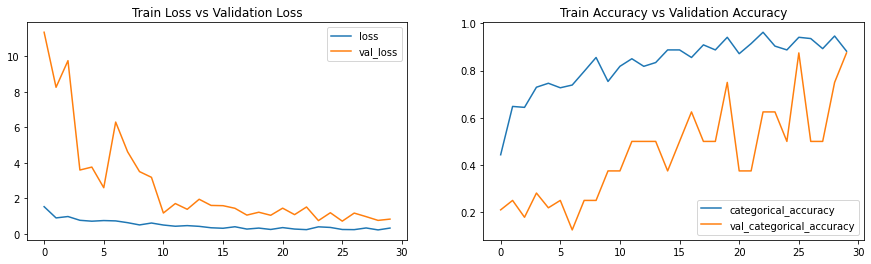

Max. Training Accuracy 0.9625668525695801
Max. Validaiton Accuracy 0.875


In [ ]:
plotHistory(model2_history)

**Model 3**: Frames:20, Epocs:20, Batch Size:64, reduced kernel to (2,2,2), switching BatchNormalization before MaxPooling.

In [ ]:
n_frames = 20
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model3 = Sequential([
    Conv3D(16, make3dFilter(2), padding='same', activation='relu', input_shape=inputShape),
    BatchNormalization(),
    MaxPooling3D(make3dFilter(2)),

    Conv3D(32, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Conv3D(64, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Conv3D(128, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_3d3")
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model3.summary())

model3_history = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 20, 100, 100, 16)  400       
_________________________________________________________________
batch_normalization_5 (Batch (None, 20, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 10, 50, 50, 16)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 10, 50, 50, 32)    4128      
_________________________________________________________________
batch_normalization_6 (Batch (None, 10, 50, 50, 32)    128       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 5, 25, 25, 32)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 5, 25, 25, 64)     164

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 4.9957 - categorical_accuracy: 0.2971  Source path =  /content/drive/MyDrive/Project_data.zip (Unzipped Files)/Project_data/val ; batch size = 64
Printing currently X, Y and Z: 20 100 100
11/11 [==============================] - 2962s 293s/step - loss: 4.9957 - categorical_accuracy: 0.2971 - val_loss: 1.5519 - val_categorical_accuracy: 0.4000

Epoch 00001: saving model to model_init_2021-09-2405_38_28.416345/model-00001-4.99574-0.29713-1.55195-0.40000.h5
Epoch 2/20
11/11 [==============================] - 182s 18s/step - loss: 1.1335 - categorical_accuracy: 0.5415 - val_loss: 2.6331 - val_categorical_accuracy: 0.1719

Epoch 00002: saving model to model_init_2021-09-2405_38_28.416345/model-00002-1.13354-0.54150-2.63311-0.17188.h5
Epoch 3/20
11/11 [==============================] - 173s 17s/step - loss: 0.8957 - categorical_accuracy: 0.6798 - val_loss: 6.1376 - val_categorical_accuracy: 0.1071

Epoch 00003: saving model 

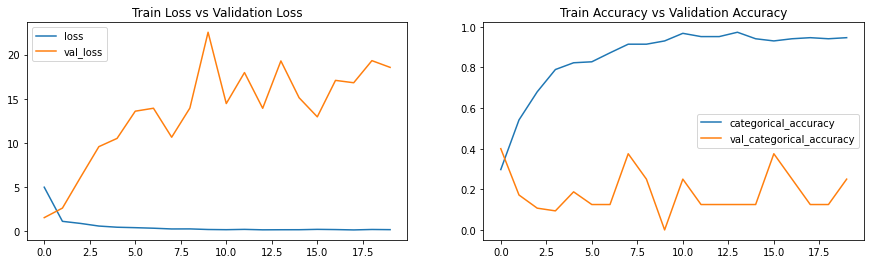

Max. Training Accuracy 0.9732620120048523
Max. Validaiton Accuracy 0.4000000059604645


In [ ]:
plotHistory(model3_history)

Model 4: Now with second Model architecture: Conv2D+GRU

In [ ]:
n_frames = 20
num_epochs = 30
batch_size = 32

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model4 = Sequential()
model4.add(TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model4.add(TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model4.add(TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model4.add(TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model4.add(TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model4.add(TimeDistributed(Flatten()))
model4.add(GRU(256))
model4.add(Dropout(0.2))
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(5, activation='softmax'))
name="conv_2d_GRU"
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model4.summary())

model4_history = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 25, 25, 64)   

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.4048 - categorical_accuracy: 0.4510  Source path =  /content/drive/MyDrive/Project_data.zip (Unzipped Files)/Project_data/val ; batch size = 32
Printing currently X, Y and Z: 20 100 100
21/21 [==============================] - 9054s 451s/step - loss: 1.4048 - categorical_accuracy: 0.4510 - val_loss: 1.5544 - val_categorical_accuracy: 0.2800

Epoch 00001: saving model to model_init_2021-09-2504_49_46.805747/model-00001-1.40482-0.45098-1.55436-0.28000.h5
Epoch 2/30
21/21 [==============================] - 355s 18s/step - loss: 0.8304 - categorical_accuracy: 0.6812 - val_loss: 2.5640 - val_categorical_accuracy: 0.1875

Epoch 00002: saving model to model_init_2021-09-2504_49_46.805747/model-00002-0.83036-0.68116-2.56403-0.18750.h5
Epoch 3/30
21/21 [==============================] - 181s 9s/step - loss: 0.7619 - categorical_accuracy: 0.7119 - val_loss: 2.5711 - val_categorical_accuracy: 0.1875

Epoch 00003: saving model t

In [ ]:
plotHistory(model4_history)

Observation:

Max. Training Accuracy 0.9327731132507324

Max. Validaiton Accuracy 0.6875

Model 5: Transfer Learning using MobileNet along with LSTM

In [ ]:
  from tensorflow.keras.applications import mobilenet

In [ ]:
mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)

n_frames = 20
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model5 = Sequential([
    TimeDistributed(mobilenet, input_shape=inputShape)
], name="mobilenet_lstm")

#for layer in model5.layers:
#    layer.trainable = False

model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model5.add(TimeDistributed(Flatten()))

model5.add(LSTM(256))
model5.add(Dropout(0.2))

model5.add(Dense(256,activation='relu'))
model5.add(Dropout(0.2))

model5.add(Dense(5, activation='softmax'))

model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model5.summary())

model5_history = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

17235968/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 1024)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 256)               1311744   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_____________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 0.8697 - categorical_accuracy: 0.6440  Source path =  /content/drive/MyDrive/Project_data.zip (Unzipped Files)/Project_data/val ; batch size = 20
Printing currently X, Y and Z: 20 100 100
34/34 [==============================] - 3633s 109s/step - loss: 0.8697 - categorical_accuracy: 0.6440 - val_loss: 0.6100 - val_categorical_accuracy: 0.8100

Epoch 00001: saving model to model_init_2021-09-2805_05_34.517409/model-00001-0.86965-0.64404-0.61001-0.81000.h5
Epoch 2/20
34/34 [==============================] - 71s 2s/step - loss: 0.5556 - categorical_accuracy: 0.8039 - val_loss: 1.4313 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to model_init_2021-09-2805_05_34.517409/model-00002-0.55563-0.80392-1.43134-0.50000.h5
Epoch 3/20
34/34 [==============================] - 75s 2s/step - loss: 0.8612 - categorical_accuracy: 0.6667 - val_loss: 1.1826 - val_categorical_accuracy: 0.6300

Epoch 00003: saving model to m

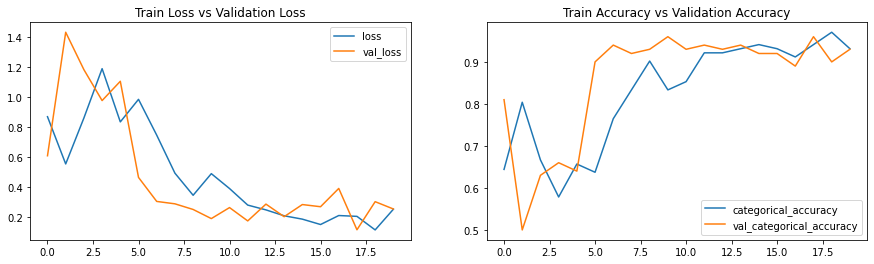

Max. Training Accuracy 0.970588207244873
Max. Validaiton Accuracy 0.9599999785423279


In [ ]:
plotHistory(model5_history)

In [ ]:
import time
from keras.models import load_model
model = load_model('/content/model_init_2021-09-2805_05_34.517409/model-00020-0.25424-0.93137-0.25612-0.93000.h5')

In [ ]:
model.summary()


Model: "mobilenet_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 1024)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 256)               1311744   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)            

In [ ]:
#type(val_generator)

In [ ]:
loss,acc = model.evaluate(val_generator)
print("loss= acc=" ,loss,acc)

In [ ]:
loss,acc = model.evaluate(val_generator)
print("loss= acc=" ,loss,acc)

**Optional Architectures tried:**
Model 6: Transfer Learning using MobileNet, this time train all weights along with GRU.

In [ ]:
from tensorflow.keras.applications import mobilenet
mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)

n_frames = 20
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model6 = Sequential([
    TimeDistributed(mobilenet, input_shape=inputShape)
], name="mobilenet_lstm")

model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model6.add(TimeDistributed(Flatten()))

model6.add(GRU(256))
model6.add(Dropout(0.2))

model6.add(Dense(256,activation='relu'))
model6.add(Dropout(0.2))

model6.add(Dense(5, activation='softmax'))

model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6.summary())

model6_history = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "mobilenet_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 20, 1024)          0         
_________________________________________________________________
gru (GRU)                    (None, 256)               984576    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)            

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20


ResourceExhaustedError: ignored

Observation: Error: OOM when allocating tensor. Let's try **Model 7** with reduce batch size to 30.



In [ ]:
from tensorflow.keras.applications import mobilenet
mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)

n_frames = 20
num_epochs = 20
batch_size = 30

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model7 = Sequential([
    TimeDistributed(mobilenet, input_shape=inputShape)
], name="mobilenet_gru")

model7.add(TimeDistributed(BatchNormalization()))
model7.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model7.add(TimeDistributed(Flatten()))

model7.add(GRU(256))
model7.add(Dropout(0.2))

model7.add(Dense(256,activation='relu'))
model7.add(Dropout(0.2))

model7.add(Dense(5, activation='softmax'))

model7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model7.summary())

model7_history = model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "mobilenet_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_8 (TimeDist (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_9 (TimeDist (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_10 (TimeDis (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 20, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               984576    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)            

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 0.8290 - categorical_accuracy: 0.6787Source path =  /content/drive/MyDrive/Project_data.zip (Unzipped Files)/Project_data/val ; batch size = 30
Printing currently X, Y and Z: 20 100 100
23/23 [==============================] - 253s 11s/step - loss: 0.8290 - categorical_accuracy: 0.6787 - val_loss: 0.7002 - val_categorical_accuracy: 0.7800

Epoch 00001: saving model to model_init_2021-09-2805_05_34.517409/model-00001-0.82902-0.67873-0.70018-0.78000.h5
Epoch 2/20
23/23 [==============================] - 39s 2s/step - loss: 0.5947 - categorical_accuracy: 0.7971 - val_loss: 0.9845 - val_categorical_accuracy: 0.6500

Epoch 00002: saving model to model_init_2021-09-2805_05_34.517409/model-00002-0.59470-0.79710-0.98450-0.65000.h5
Epoch 3/20
23/23 [==============================] - 39s 2s/step - loss: 1.0503 - categorical_accuracy: 0.7101 - val_loss: 0.9996 - val_categorical_accuracy: 0.6500

Epoch 00003: saving model to model

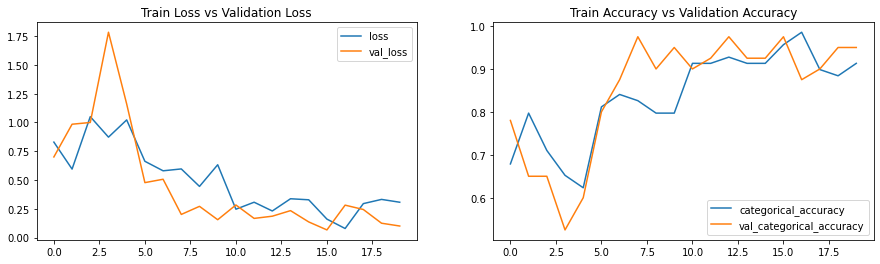

Max. Training Accuracy 0.9855072498321533
Max. Validaiton Accuracy 0.9750000238418579


In [ ]:
plotHistory(model7_history)

**With all the experiments so far, we finalized Model 4 - CONV2D+ GRU, which performed well.**

Reason:

- (Training Accuracy : 97%, Validation Accuracy : 87%).

- It is an RNN.

- Number of Parameters less according to other models performance

- Learning rate gradually improved with Epoch.

**Due to file size limitation on Upgrad platform, attaching various models H5 files into G drive, which are accessible for review**.
https://drive.google.com/drive/folders/1cnM4up3vskxthxs9kjfsAo2KqmEpYpr4?usp=sharing
